In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
! git clone https://github.com/metal3d/keras-video-generators.git

Cloning into 'keras-video-generators'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 614 (delta 47), reused 75 (delta 35), pack-reused 514
Receiving objects: 100% (614/614), 7.77 MiB | 20.13 MiB/s, done.
Resolving deltas: 100% (279/279), done.


In [3]:
import os
# 다운로드한 폴더로 이동
os.chdir("/content/keras-video-generators/")

In [4]:
# git 컴파일
! python setup.py build

/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'licence_file'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib
creating build/lib/keras_video
copying src/keras_video/__init__.py -> build/lib/keras_video
copying src/keras_video/utils.py -> build/lib/keras_video
copying src/keras_video/sliding.py -> build/lib/keras_video
copying src/keras_video/generator.py -> build/lib/keras_video
copying src/keras_video/flow.py -> build/lib/keras_video


In [5]:
# 폴더 생성
! mkdir /content/keras_video
# git 파일 복사 /content/keras_video
! cp /content/keras-video-generators/build/lib/keras_video/*.*  /content/keras_video

In [6]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_video import VideoFrameGenerator
import sklearn
from tensorflow.keras.models import Sequential
from keras.applications import vgg16, vgg19
from tensorflow.keras.layers import TimeDistributed, GRU, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import keras_video.utils
from tensorflow_docs.vis import embed
import imageio

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import models

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
model_path = '/content/drive/MyDrive/모듈프로젝트4_team8/택완/cnn+lstm(82.48).h5'

In [9]:
# CNN 모델 읽기
model = tf.keras.models.load_model(
    model_path
#    custom_objects={'loss': 'sparse_categorical_crossentropy'}
    ,custom_objects=None
    )

In [10]:
model.input

<KerasTensor: shape=(None, 10, 224, 224, 3) dtype=float32 (created by layer 'time_distributed_input')>

In [11]:
model.output

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_2')>

In [12]:
model.layers

In [13]:
layers = [ layer.output for layer in model.layers[:] ]
layers

[<KerasTensor: shape=(None, 10, 224, 224, 32) dtype=float32 (created by layer 'time_distributed')>,
 <KerasTensor: shape=(None, 10, 112, 112, 32) dtype=float32 (created by layer 'time_distributed_1')>,
 <KerasTensor: shape=(None, 10, 112, 112, 64) dtype=float32 (created by layer 'time_distributed_2')>,
 <KerasTensor: shape=(None, 10, 112, 112, 64) dtype=float32 (created by layer 'time_distributed_3')>,
 <KerasTensor: shape=(None, 10, 56, 56, 64) dtype=float32 (created by layer 'time_distributed_4')>,
 <KerasTensor: shape=(None, 10, 56, 56, 128) dtype=float32 (created by layer 'time_distributed_5')>,
 <KerasTensor: shape=(None, 10, 56, 56, 128) dtype=float32 (created by layer 'time_distributed_6')>,
 <KerasTensor: shape=(None, 10, 28, 28, 128) dtype=float32 (created by layer 'time_distributed_7')>,
 <KerasTensor: shape=(None, 10, 28, 28, 256) dtype=float32 (created by layer 'time_distributed_8')>,
 <KerasTensor: shape=(None, 10, 28, 28, 256) dtype=float32 (created by layer 'time_distrib

In [14]:
activation_model = models.Model(inputs=model.input, outputs=layers)
activation_model

In [15]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_input (Inpu [(None, 10, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 224, 224, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 112, 112, 32)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 112, 112, 64)  18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 112, 112, 64)  36928     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 56, 56, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 56, 56, 128)   73856 

In [16]:
X_train = np.load('/content/drive/MyDrive/모듈프로젝트4_team8/택완/X.npy')
y_train = np.load('/content/drive/MyDrive/모듈프로젝트4_team8/택완/y.npy')

In [17]:
print(X_train.shape)
print(y_train.shape)

(356, 15, 224, 224, 3)
(356, 3)


### 비디오 증강

In [18]:
# 데이터 경로
data_path = "/content/drive/MyDrive/cloud_ai/16.모듈프로젝트04/workspace/"

In [19]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")

In [20]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [21]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [22]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df=sklearn.utils.shuffle(train_df)

In [23]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
237,v_Punch_g25_c06.avi,Punch,Punch
196,v_Punch_g19_c04.avi,Punch,Punch
127,v_Punch_g09_c03.avi,Punch,Punch
207,v_Punch_g21_c04.avi,Punch,Punch
33,v_CricketShot_g12_c06.avi,CricketShot,CricketShot
...,...,...,...
283,v_TennisSwing_g14_c04.avi,TennisSwing,TennisSwing
307,v_TennisSwing_g17_c07.avi,TennisSwing,TennisSwing
308,v_TennisSwing_g18_c01.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing


In [24]:
# tag에 저장된 라벨을 리턴
classes = train_df["tag"].unique().tolist()

In [25]:
# 라벨 정렬
classes.sort()

In [26]:
# 라벨 데이터 조회
classes

['CricketShot', 'Punch', 'TennisSwing']

In [27]:
# train, validation data 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [28]:
# 이미지 사이즈
SIZE = (224, 224)
CHANNELS = 3

In [29]:
# 비디오 프레임의 이미지를 변형 할 객체 변형할 객체
train_image_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30, # 이미지 회전 각도 최대 30도
	zoom_range=0.15, # 이미지 확대 비율 
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전을 가능하도록 설정
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
)

In [30]:
# 비디오 파일의 클래스 v_다음이 클래스임
glob_pattern=data_path+'train/v_{classname}_*.avi'

In [31]:
# 비디오 프레임 !!!15!!!개 생성할 객체
train_video_generator = VideoFrameGenerator(
    classes=classes, # 분류할 클래스 설정 : ['CricketShot', 'Punch', 'TennisSwing']
    glob_pattern=glob_pattern, # 파일명에서 클래스 정보를 따옴
    nb_frames=15,              # 시퀀스의 프레임의 수 
    split=.33,                 # 검증용 파일로 나눌 분할 비율 
    shuffle=True,              # 섞을 것 인지 
    batch_size=2,              # 배치사이즈는 2로 설정 한 배치의 시퀀스 수
    target_shape=SIZE,         # 요소 2에서 만든 (224,224)
    nb_channel=CHANNELS,       # 요소 2에서 만든 3  3이니까 RGB 채널 
    transformation=train_image_data_gen, # 요소 3에서 만든 비디오 프레임의 변형 
    use_frame_cache=True       # 프레임 캐시를 사용할지 여부 / 사용을 위해 다량의 메모리 필요 
    )

Total data: 3 classes for 356 files for train


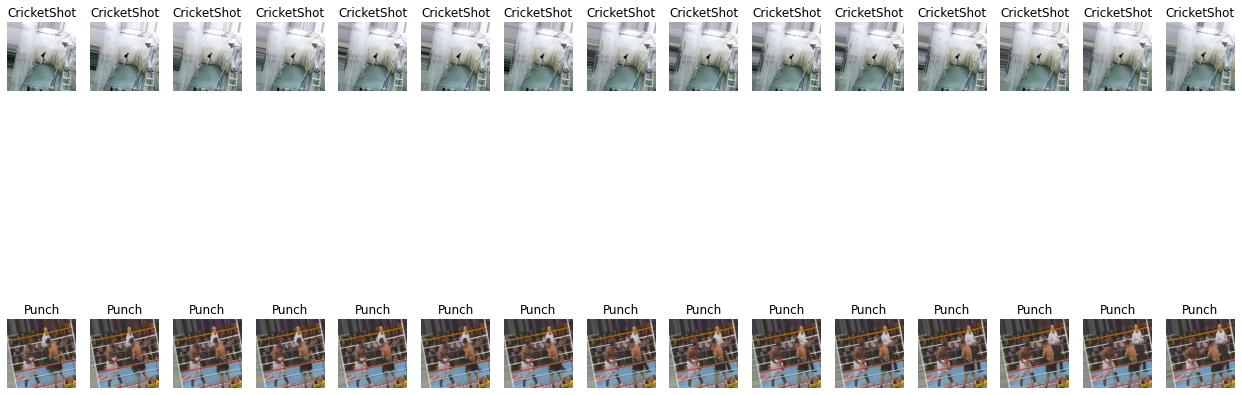

In [32]:
# 비디오 프레임 샘플 데이터 조회 (배치사이즈 만큼)
keras_video.utils.show_sample(train_video_generator)

In [ ]:
# input_shape= (15, 224,224,3)

model = Sequential()
model.add(time_distributed( Conv2D(32 input_shape=(15, 224, 224, 32) ) )

model.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), padding= 'SAME', activation='relu') ,input_shape=(15, 224, 224, 3)))
# model.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), padding= 'SAME', activation='relu')))

model.add(TimeDistributed(MaxPooling2D(pool_size =(2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(128, kernel_size=(3,3) ,padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(128, kernel_size=(3,3) ,padding="SAME", activation="relu")))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3),padding="SAME", activation="relu")))
model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3),padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3),padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(256, kernel_size=(3,3),padding="SAME", activation="relu")))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))
model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))
model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))
# model.add(TimeDistributed(Conv2D(512, kernel_size=(3,3),padding="SAME", activation="relu")))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2,2))))


model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

model.add(LSTM(1024, dropout=0.5))

model.add(Dense(512,  activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512,  activation="relu"))
model.add(Dropout(0.75))

model.add(Dense(3, activation="softmax"))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 224, 224, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 112, 112, 32)  0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 112, 112, 64)  18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 112, 112, 64)  36928     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 56, 56, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 56, 56, 128)   73856     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 56, 56, 128)   1

In [34]:
model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)
                ,loss='categorical_crossentropy'
                ,metrics=['accuracy']
            )

In [38]:
# checkpoint 만들기
checkpoint_path = '/content/drive/MyDrive/sukhee.cloud.ai/tmp_checkpoint.ckpt'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path
    ,save_weights_only=True
    ,save_best_only=True
    ,monitor='val_loss'
    ,verbose=1
)

In [40]:
# 이미지 학습
model.fit(
	train_video_generator
#	,X_train, y_train
	,batch_size=1
	,epochs=50 # lr : 1e-5
	,validation_data=(X_val, y_val)
	,callbacks=[checkpoint]
	,verbose=1
)

Epoch 1/35


InvalidArgumentError: ignored

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.save('/content/drive/MyDrive/sukhee.cloud.ai/CNN+LSTM_cv,vg,cb(lr=1e5,ep=50).h5')

### test

### 비디오 증강

In [ ]:
shuffled_test_df = pd.read_csv('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/shuffled_test.csv')
shuffled_test_df

In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
shuffled_test_df=sklearn.utils.shuffle(shuffled_test_df)

In [ ]:
# tag에 저장된 라벨을 리턴
classes = shuffled_test_df["tag"].unique().tolist()

In [ ]:
# 라벨 정렬
classes.sort()

In [ ]:
# 라벨 데이터 조회
classes

In [ ]:
# 이미지 사이즈
SIZE = (224, 224)
CHANNELS = 3

In [ ]:
# 비디오 프레임의 이미지를 변형 할 객체 변형할 객체
test_image_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30, # 이미지 회전 각도 최대 30도
	zoom_range=0.15, # 이미지 확대 비율 
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전을 가능하도록 설정
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
)

In [ ]:
# 비디오 파일의 클래스 v_다음이 클래스임
glob_pattern = data_path+'test/v_{classname}_*.avi'

In [ ]:
# 비디오 프레임 20개 생성할 객체
test_video_generator = VideoFrameGenerator(
    classes=classes, # 분류할 클래스 설정 : ['CricketShot', 'Punch', 'TennisSwing']
    glob_pattern=glob_pattern, # 파일명에서 클래스 정보를 따옴
    nb_frames=20,              # 시퀀스의 프레임의 수 
    split=.33,                 # 검증용 파일로 나눌 분할 비율 
    shuffle=True,              # 섞을 것 인지 
    batch_size=2,              # 배치사이즈는 2로 설정 한 배치의 시퀀스 수
    target_shape=SIZE,         # 요소 2에서 만든 (224,224)
    nb_channel=CHANNELS,       # 요소 2에서 만든 3  3이니까 RGB 채널 
    transformation=test_image_data_gen, # 요소 3에서 만든 비디오 프레임의 변형 
    use_frame_cache=True       # 프레임 캐시를 사용할지 여부 / 사용을 위해 다량의 메모리 필요 
    )

In [ ]:
import keras_video.utils
# 비디오 프레임 샘플 데이터 조회 (배치사이즈 만큼)
keras_video.utils.show_sample(test_video_generator)

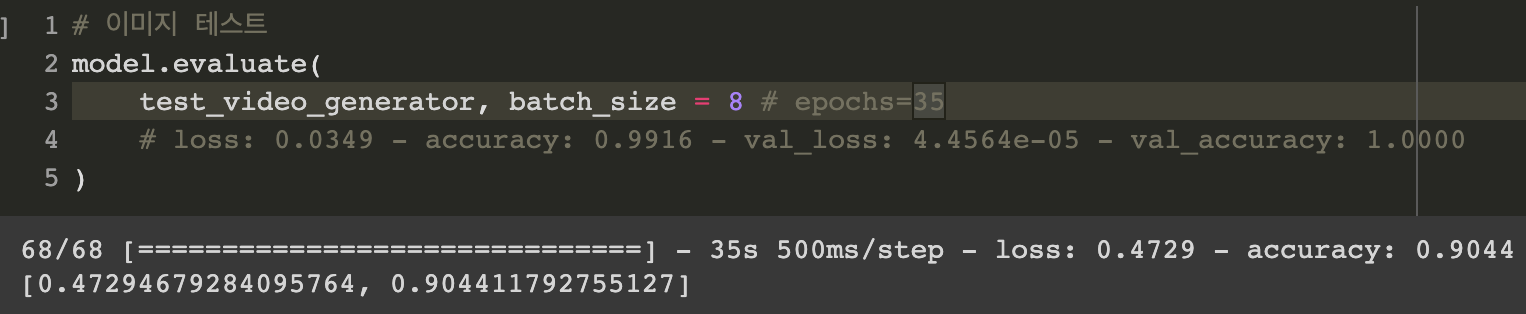

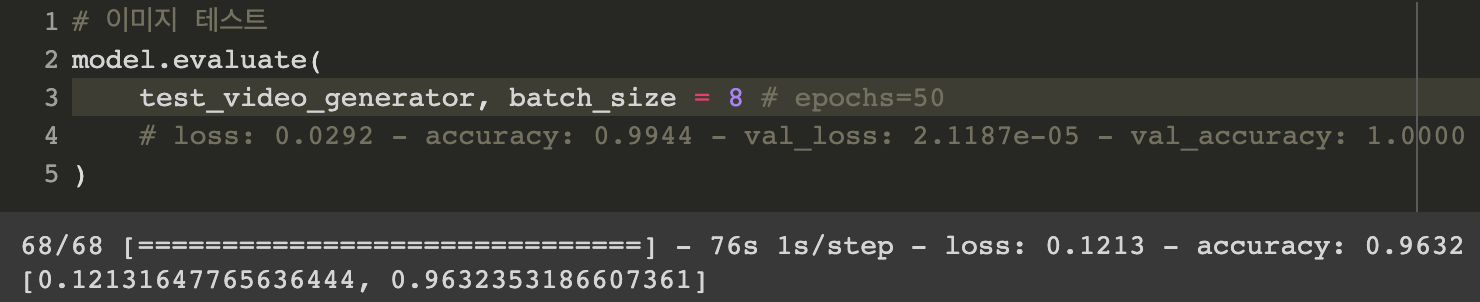

In [ ]:
# 이미지 테스트
model.evaluate(
    test_video_generator, batch_size = 8 # epochs=50
    # loss: 0.0292 - accuracy: 0.9944 - val_loss: 2.1187e-05 - val_accuracy: 1.0000
)

In [ ]:
classes

In [ ]:
X_test = np.load('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/X_test(5).npy')
y_test = np.load('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/y_test(5).npy')

In [ ]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_test[0][0])

In [ ]:
# 0번째 비디오 프레임 이미지
frame = X_test[90:91]
# 비디오 프레임 이미지의 종류 예측
predict01 = model.predict(frame)
print("predict01 = ", predict01)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
print("predict02 = ", predict02)
# 이미지의 종류 조회
text_predict = classes[predict02[0]]
print("text_predict=", text_predict)

In [ ]:
# 0번째 비디오 프레임 이미지 image에 대입
image = frame[0][0].copy()
plt.imshow(image)

In [ ]:
# 이미지의 종류
str = "Activity :{}".format(text_predict)
# str을 출력할 이미지 좌표
org=(0,20) 
# 이미지 폰트
font=cv2.FONT_HERSHEY_PLAIN
# image에 str을 출력
cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)

In [ ]:
# image에 str (영상 종류 예측값 ) 출력
plt.imshow(image)

In [ ]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(20,224,224,3))
# X_test의 0번째 비디오
frame = X_test[0:1]
# 비디오  종류 예측
predict01 = model.predict(frame)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
# 이미지의 종류 조회
text_predict = classes[predict02[0]]
# 이미지의 종류
str = "Activity :{}".format(text_predict)
print("str = ", str)
for i in range(20):
    #frame 복사
    image = frame[0][i].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을  출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image * 255

In [ ]:
# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=20)
# animation.gif 를 출력
embed.embed_file("animation.gif")